In [1]:
# Cell 1: Notebook setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
sns.set(style="whitegrid")

# Optional: Increase column visibility
pd.set_option('display.max_columns', None)

# Paths
RAW_DATA_PATH = '../data/raw'
PROCESSED_DATA_PATH = '../data/processed'


In [2]:
# Cell 2: Load all three datasets
fraud_df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'Fraud_Data.csv'))
credit_df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'creditcard.csv'))
ip_df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'IpAddress_to_Country.csv'))

# Quick shape check
fraud_df.shape, credit_df.shape, ip_df.shape


((151112, 11), (284807, 31), (138846, 3))

In [3]:
# Cell 3: Overview
fraud_df.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
# Cell 4: Missing values and dtypes
fraud_df.info()
fraud_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [5]:
# Cell 5: Drop duplicates and parse datetimes
fraud_df = fraud_df.drop_duplicates()
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Confirm changes
fraud_df.dtypes


user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

In [9]:
# Cell 6: Convert IP to integer for join
def ip_to_int(ip):
    try:
        if pd.isnull(ip):
            return np.nan
        parts = list(map(int, str(ip).split('.')))
        if len(parts) != 4:
            return np.nan
        return (parts[0] << 24) + (parts[1] << 16) + (parts[2] << 8) + parts[3]
    except:
        return np.nan
fraud_df['ip_int'] = fraud_df['ip_address'].apply(ip_to_int)

In [10]:
# Cell 7: Map IP to Country (using searchsorted logic)
ip_df = ip_df.sort_values('lower_bound_ip_address')

def map_ip_to_country(ip_val):
    row = ip_df[
        (ip_df['lower_bound_ip_address'] <= ip_val) &
        (ip_df['upper_bound_ip_address'] >= ip_val)
    ]
    if not row.empty:
        return row['country'].values[0]
    else:
        return 'Unknown'

fraud_df['country'] = fraud_df['ip_int'].apply(map_ip_to_country)


In [11]:
# Cell 8: Time-based features
fraud_df['transaction_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['transaction_dayofweek'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600

# Frequency-based features
fraud_df['transactions_per_device'] = fraud_df.groupby('device_id')['device_id'].transform('count')
fraud_df['user_transaction_count'] = fraud_df.groupby('user_id')['user_id'].transform('count')


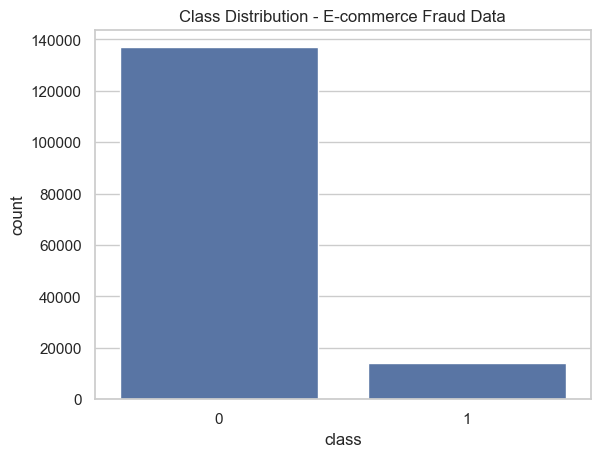

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64

In [12]:
# Cell 9: Class distribution
sns.countplot(x='class', data=fraud_df)
plt.title('Class Distribution - E-commerce Fraud Data')
plt.show()

# Numeric
fraud_df['class'].value_counts(normalize=True)


In [13]:
# Cell 10: Save cleaned & enriched data
fraud_df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'cleaned_fraud_data.csv'), index=False)


In [14]:
# Cell 11: Inspect creditcard dataset
credit_df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
# Cell 12: Check missing values and data types
credit_df.info()
credit_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

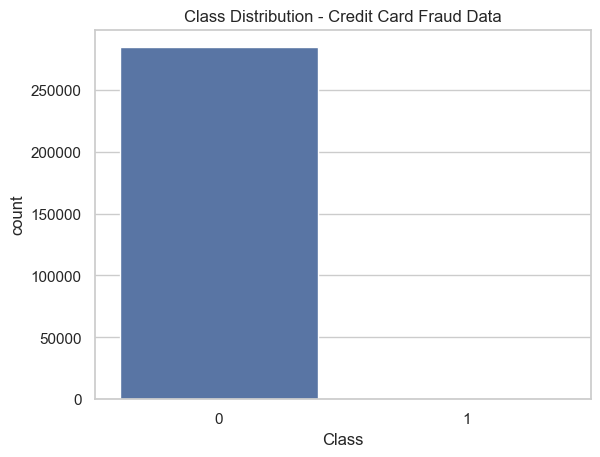

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [16]:
# Cell 13: Class distribution
sns.countplot(x='Class', data=credit_df)
plt.title('Class Distribution - Credit Card Fraud Data')
plt.show()

# Numeric distribution
credit_df['Class'].value_counts(normalize=True)


In [17]:
# Cell 14: Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
credit_df[['scaled_amount', 'scaled_time']] = scaler.fit_transform(credit_df[['Amount', 'Time']])

# Drop original columns
credit_df = credit_df.drop(columns=['Amount', 'Time'])

# Reorder columns for readability
scaled_cols = ['scaled_amount', 'scaled_time'] + [col for col in credit_df.columns if col not in ['Amount', 'Time', 'scaled_amount', 'scaled_time']]
credit_df = credit_df[scaled_cols]


In [18]:
# Cell 15: Save to processed directory
credit_df.to_csv(os.path.join(PROCESSED_DATA_PATH, 'cleaned_creditcard_data.csv'), index=False)
